## Pianix


The goal of the `Pianix` project is to harness artificial intelligence (AI), specifically through a recurrent neural network (RNN) model, to create music that mirrors the ambient piano genre.

The methodology adopted in this project is capable of generating original musical pieces, resembling the style and emotive qualities found in human-made compositions. The project's objective is to explore how RNNs can be utilized to produce innovative and engaging music suitable for various uses, such as sharing on social media platforms.


AI-generated music could serve various purposes and find applications in different contexts:

- **Music Production**: It can be used by composers and musicians to generate ideas, inspire creativity, or even assist in composing new pieces.

- **Education**: It could be employed as a teaching tool in music education to demonstrate different musical styles, techniques, or historical compositions.

- **Content Creation**: AI-generated music can enhance multimedia content such as videos, podcasts, or presentations, adding a professional and unique touch.

- **Background Music**: It can provide background music for various settings like restaurants, cafes, or stores, creating a pleasant atmosphere.

- **Personal Enjoyment**: Individuals can use Pianix to create custom playlists for relaxation, focus, or mood enhancement.

- **Social Media**: The generated music can be shared on social media platforms to engage audiences, promote brands, or enhance user experiences.

- **Game Development**: It can contribute to the development of video games by providing dynamic and immersive soundtracks.

- **Film and TV Production**: It could be used by filmmakers and producers to create original scores or background music for movies, TV shows, or commercials.

- **Therapeutic Applications**: AI-generated music might be utilized in therapeutic settings such as music therapy sessions, relaxation programs, or stress relief activities.

- **Artistic Exploration**: Artists and enthusiasts can experiment with AI to explore new musical landscapes, styles, or combinations beyond traditional compositions.

## Dataset

### Loading the dataset

To train our model, we will utilize ADL Piano MIDI dataset comprising 11,086 piano pieces from different genres (source: https://github.com/lucasnfe/adl-piano-midi)

In [2]:
# unzip data into classical_midi directory
!unzip -q 'adl-piano-midi'

The dataset consists of midi files from various genres. We'll use Ambient category for this project



In [3]:
import glob

data_dir = "/content/adl-piano-midi/Ambient"

# Get paths to all .mid files in the data_dir
midi_paths = glob.glob(f'{data_dir}/**/*.mid', recursive=True)

print(f"Number of MIDI files found in {data_dir}: {len(midi_paths)}")

Number of MIDI files found in /content/adl-piano-midi/Ambient: 185


### Exploring the dataset
First, let's look at the contents of a sample midi file. 

In [73]:
import warnings
warnings.filterwarnings('ignore')

import random

midi_file_path = random.choice(midi_paths)
print(f'sample midi file: {midi_file_path}')


sample midi file: /content/adl-piano-midi/Ambient/New Age/Tom Barabas/Piano Concerto In C Major.mid


To analyze the contents of a .mid file, we'll employ the `music21` library. Each MIDI file contains one score which may consist of multiple parts, each potentially representing a different instrument.

In [74]:
from music21 import converter

def view_part_details(midi_file_path):
    # Parse MIDI file
    score = converter.parse(midi_file_path)

    # Iterate over each part in the MIDI file
    for i, part in enumerate(score.parts):
        print(f"Part {i}: {part.partName}")  # Print the name of the part, if available


# Example usage:
view_part_details(midi_file_path)


Part 0: Piano


The `get_notes_from_midi` function takes a MIDI file path as input and returns a list containing note numbers, durations, and velocities.

- **Note Numbers**: In MIDI (Musical Instrument Digital Interface), each musical note is represented by a number. These numbers typically range from 0 to 127, where each number corresponds to a specific pitch on a standard piano keyboard. For example, middle C is usually represented by the note number 60.

- **Duration**: Duration in MIDI refers to the length of time a note is held or sustained. It's typically measured in ticks, where each tick represents a fraction of a beat. The duration indicates how long a note should be played before moving to the next note.

- **Velocity**: Velocity represents the intensity or loudness with which a note is played. It's also measured on a scale from 0 to 127, where 0 indicates no velocity (essentially silence) and 127 represents the maximum velocity (maximum loudness). Higher velocity values typically result in louder sounds, while lower values produce softer sounds.


\* Long-duration notes may represent sustained tones or passages, which might not contribute as significantly to the melodic contour or development of a piece. Filtering them out can help focus the analysis on the melodic phrases that drive the musical narrative. As such, this function filters out notes with duration > 2.5 s

In [75]:
from music21 import converter, note, midi

def get_notes_from_midi(midi_file_path, part_no=None):
  """
  This function takes a midi file path and returns a 3d numpy array containing the notes numbers, duration of each, and velocity of each.
  """
  notes = []
  score = converter.parse(midi_file_path)
  if part_no:
    selected_part = score.parts[part_no]
  else:
    selected_part = score  # all parts

  # Get all the notes and chords from the midi file
  for element in selected_part.flat.notes:
    if isinstance(element, note.Note):
      notes.append(element)

  # Iterate over the notes and fill the numpy array
  note_numbers, note_durations, note_velocities = [], [], []
  for element in notes:
    ql = float(element.duration.quarterLength)
    if ql <= 2.5:
      note_numbers.append(element.pitch.midi)  # Note number
      note_durations.append(ql)  # Duration of the note
      note_velocities.append(element.volume.velocity)  # Velocity of the note

  return note_numbers, note_durations, note_velocities

note_numbers, note_durations, note_velocities = get_notes_from_midi(midi_file_path)
print(f'note_numbers: {note_numbers}')
print(f'note_durations: {note_durations}')
print(f'note_velocities: {note_velocities}')



note_numbers: [53, 53, 53, 53, 48, 78, 79, 48, 48, 76, 79, 48, 82, 48, 53, 80, 81, 53, 45, 57, 48, 58, 46, 58, 47, 59, 48, 60, 84, 60, 60, 60, 69, 81, 62, 77, 74, 57, 79, 76, 73, 50, 74, 74, 76, 77, 50, 77, 79, 81, 82, 82, 48, 79, 79, 76, 76, 72, 79, 70, 53, 72, 69, 53, 72, 77, 81, 52, 84, 79, 79, 52, 77, 76, 74, 53, 74, 74, 74, 76, 78, 79, 83, 84, 72, 55, 72, 67, 67, 79, 80, 74, 73, 74, 75, 77, 79, 72, 71, 72, 74, 75, 77, 71, 69, 71, 72, 74, 75, 69, 68, 69, 71, 72, 74, 67, 66, 53, 67, 69, 71, 72, 52, 84, 55, 60, 48, 52, 60, 57, 57, 60, 74, 62, 53, 60, 62, 55, 60, 62, 55, 79, 59, 62, 56, 77, 59, 62, 57, 76, 60, 64, 55, 60, 64, 53, 59, 62, 72, 52, 84, 55, 60, 48, 52, 60, 57, 57, 60, 74, 62, 53, 60, 62, 55, 60, 62, 55, 79, 59, 65, 55, 58, 62, 55, 58, 62, 55, 58, 62, 55, 58, 62, 55, 58, 61, 55, 58, 61, 55, 58, 61, 55, 58, 62, 55, 81, 57, 64, 55, 57, 64, 58, 82, 77, 79, 69, 60, 75, 84, 81, 53, 87, 84, 81, 53, 77, 75, 58, 77, 74, 58, 75, 78, 81, 84, 87, 70, 74, 79, 82, 86, 73, 76, 79, 82, 8

To better illustrate the information we extracted from a MIDI file, we'll create a visualization of notes data, showcasing note numbers along the y-axis, durations along the x-axis, and velocities through color.


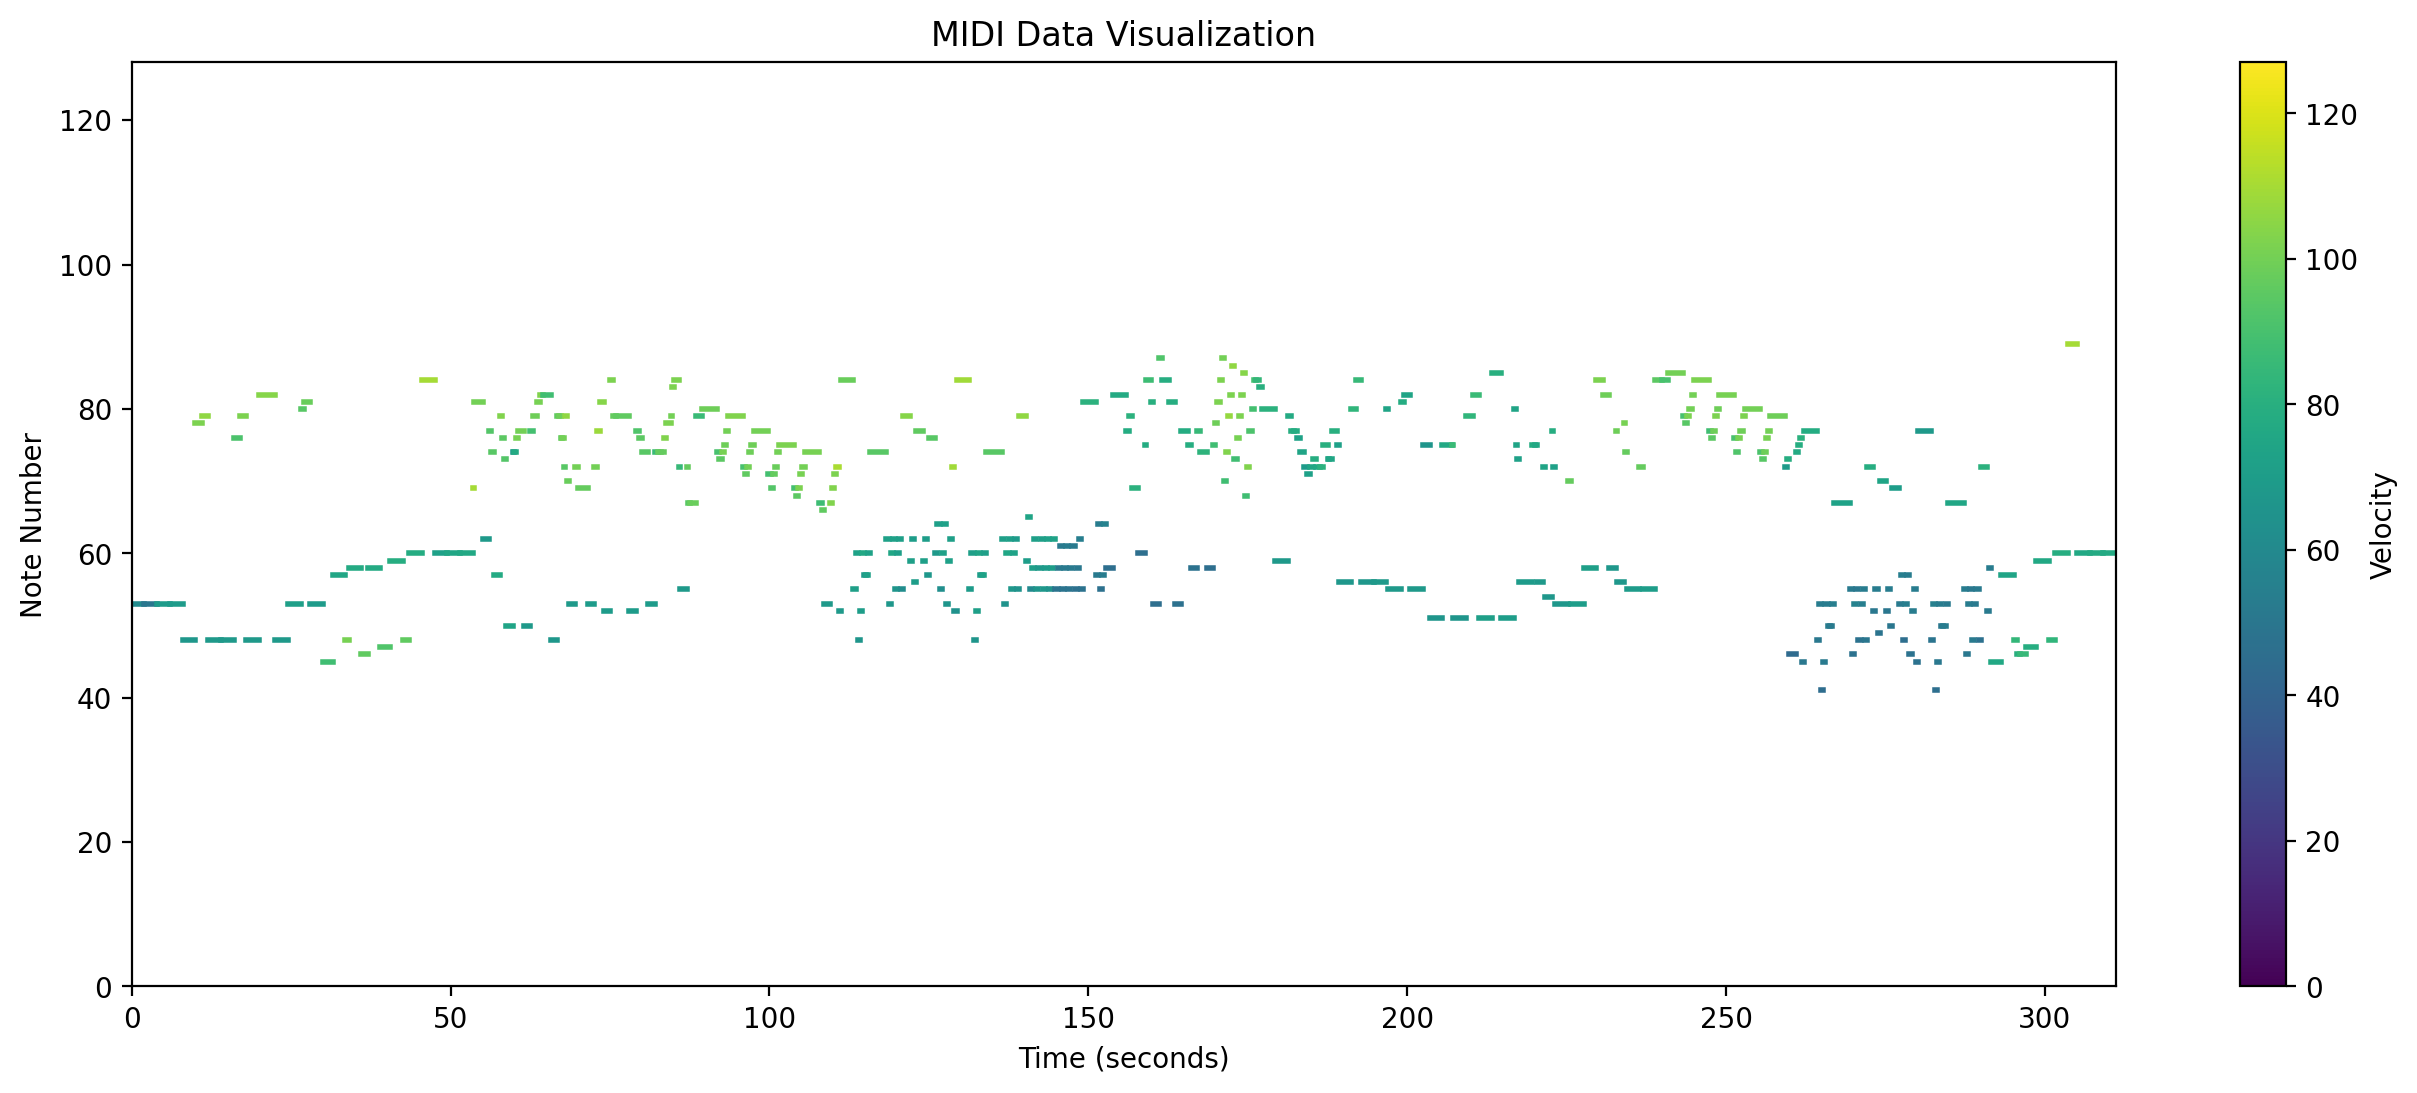

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midi_data(note_numbers, note_durations, note_velocities):

    # Calculate cumulative durations
    cumulative_durations = np.cumsum(note_durations)

    plt.figure(figsize=(16, 6))
    
    # Plot each note as a line
    for i in range(len(note_numbers)):
        start_time = 0 if i == 0 else cumulative_durations[i-1]  # Start time of the current note
        end_time = cumulative_durations[i]  # End time of the current note

        plt.plot([start_time, end_time], [note_numbers[i], note_numbers[i]], color=plt.cm.viridis(note_velocities[i]/127), linewidth=2)

    # Set plot labels and title
    plt.xlim([0,sum(note_durations)])
    plt.ylim([0,128])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Note Number')
    plt.title('MIDI Data Visualization')

    # Add color bar for velocity
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=127))
    sm.set_array([])
    plt.colorbar(sm, label='Velocity')

    # Show plot
    plt.show()

visualize_midi_data(note_numbers, note_durations, note_velocities)


We can also listen to a MIDI file, using the function below.

In [86]:
# Play the MIDI file

def play_midi_file(midi_file_path):
  mf = midi.MidiFile()
  mf.open(midi_file_path)
  mf.read()
  mf.close()
  s = midi.translate.midiFileToStream(mf)
  s.show('midi')

play_midi_file(midi_file_path)

A MIDI file contains various elements such as notes, chords, and others. However, for our purpose, we are solely interested in notes. Therefore, we'll create a function called `play_notes` to produce audio based on a provided list of notes, durations, and velocities, which are the details we extract from a MIDI file.

In [84]:
from music21 import stream, duration

def play_notes(note_numbers, note_durations=None, note_velocities=None):
    if note_durations is None:
        note_durations = [0.5] * len(note_numbers)

    if note_velocities is None:
        note_velocities = [100] * len(note_numbers)

    # Create a stream object
    stream_obj = stream.Stream()

    # Add notes to the stream
    for i in range(len(note_numbers)):
        new_note = note.Note()
        new_note.pitch.midi = note_numbers[i]
        new_note.volume.velocity = note_velocities[i]
        new_note.duration = duration.Duration(note_durations[i])  # Ensure duration is a Duration object
        stream_obj.append(new_note)

    # Play the stream
    stream_obj.show('midi')

play_notes(note_numbers, note_durations, note_velocities)


To create our training data, we'll randomly pick 50 midi files from Ambient genre. then we'll use `get_notes_from_midi` function to exract note numbers, durations,and velocities from each and store all in 3 lists.

In [10]:
n_midi_files = 50
selected_midi_files = random.sample(midi_paths, n_midi_files)
# print("selected MIDI files:\n" +  "\n".join(selected_midi_files))


In [11]:
from tqdm import tqdm

note_numbers_all, note_durations_all, note_velocities_all = [], [], []
for midi_path in tqdm(selected_midi_files, desc='parsing midi files'):
    note_numbers, note_durations, note_velocities = get_notes_from_midi(midi_path)
    note_numbers_all.append(note_numbers)
    note_durations_all.append(note_durations)
    note_velocities_all.append(note_velocities)



parsing midi files: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


## Preprocessing

First, let's look at some statistics on the extracted note data. In particular, we are interested in examining the distribution of note numbers, durations, and velocities within our chosen dataset.

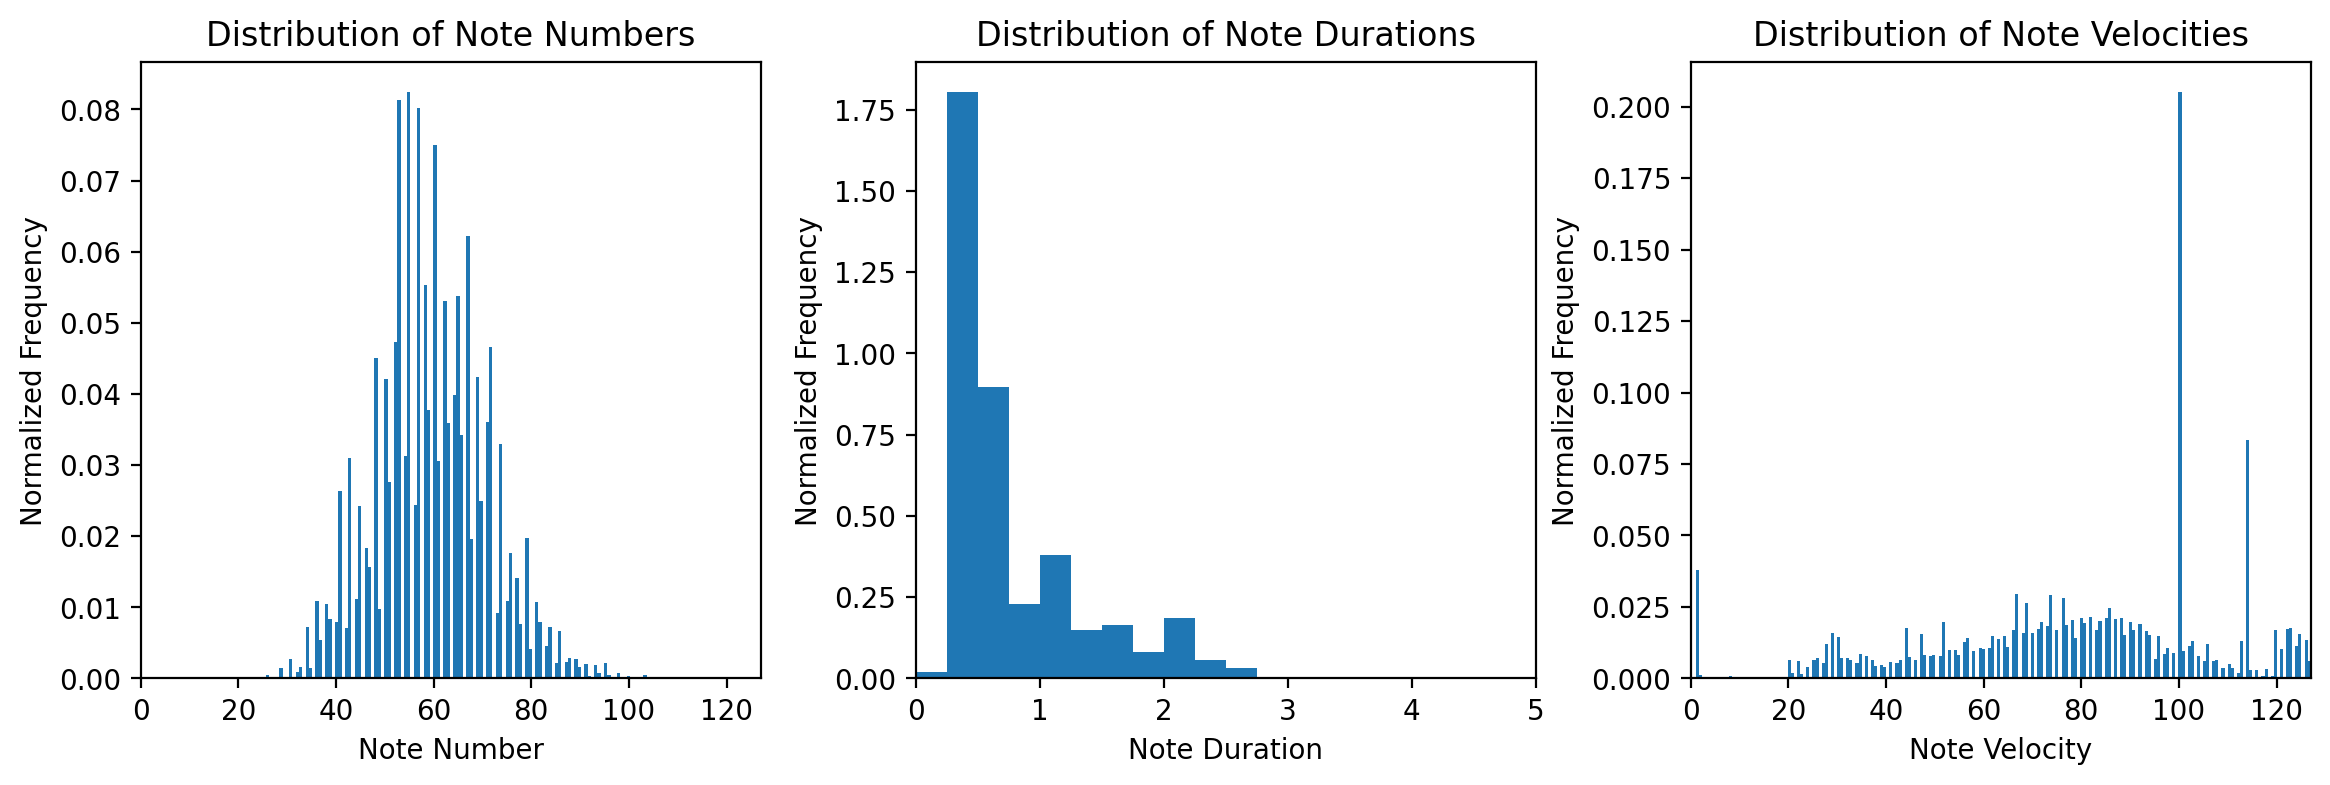

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Plot distribution of note_numbers_all
axes[0].hist(np.hstack(note_numbers_all), bins=128, density=True)
axes[0].set_xlabel('Note Number')
axes[0].set_ylabel('Normalized Frequency')
axes[0].set_title('Distribution of Note Numbers')
axes[0].set_xlim([0, 127])

# Plot distribution of note_durations_all
axes[1].hist(np.hstack(note_durations_all), bins=np.arange(0., 10., 0.25), density=True)
axes[1].set_xlabel('Note Duration')
axes[1].set_ylabel('Normalized Frequency')
axes[1].set_title('Distribution of Note Durations')
axes[1].set_xlim([0, 5])

# Plot distribution of note_velocities_all
axes[2].hist(np.hstack(note_velocities_all), bins=200, density=True)
axes[2].set_xlabel('Note Velocity')
axes[2].set_ylabel('Normalized Frequency')
axes[2].set_title('Distribution of Note Velocities')
axes[2].set_xlim([0, 127])

fig.subplots_adjust(wspace=0.25)

plt.show()



### Padding

Padding is a technique commonly used in sequence modeling to standardize the lengths of sequences in a dataset. It involves adding special tokens, to sequences that are shorter than a specified length, typically the maximum length in the dataset. This ensures that all sequences have the same length.

Standardizing sequence lengths is crucial for training neural networks effectively. It facilitates batch processing and ensures that the model learns from sequences of uniform length, which is essential for efficient training.

To pad the sequences in `X` to a consistent length (in this case, `max_seq_len=8` for efficiency), we will utilize the `create_sequences` function to prepare sequences of note numbers and durations for training a model. Here's how it works:

- `mask_1_value` and `mask_2_value` are used for padding the shorter than required sequences, and the masking layer in the RNN model.
- The function takes three parameters: `note_numbers_all`, `note_durations_all`, and `max_seq_len`
- It iterates over each MIDI file's note numbers and durations provided in `note_numbers_all` and `note_durations_all`.
- For each MIDI file, it creates sequences of note numbers and durations along with their corresponding next notes/durations.
- The length of these sequences is determined by `max_seq_len`.
- It then pads these sequences with mask values (`mask_1_value` and `mask_2_value`) to ensure uniform length.
- The function returns four arrays: `padded_X1` (padded sequences of note numbers), `y1` (next note numbers), `padded_X2` (padded sequences of durations), and `y2` (next durations).
- Outputs are then assigned to variables `X1`, `y1`, `X2`, and `y2` outside the function call.

\* By multiplying the durations by 12 within this function, it guarantees that the values of X2 and y2 are represented as whole integers.

In [13]:
mask_1_value = 128
mask_2_value = 0

def create_sequences(note_numbers_all, note_durations_all, max_seq_len):
  """
  Creates sequences of note numbers and durations with the same len, as X1/X2 and next note/duration as y1/y2.
  """
  X1, y1, X2, y2 = [], [], [], []
  for i in tqdm(range(len(note_numbers_all)), desc='creating sequences'):
    note_numbers, note_durations = note_numbers_all[i], note_durations_all[i]
    for j in range(1, len(note_numbers)):

      X1.append(note_numbers[max(0, j-max_seq_len):j])
      y1.append(note_numbers[j])

      X2.append(note_durations[max(0, j-max_seq_len):j])
      y2.append(note_durations[j])

  padded_X1 = np.array([[mask_1_value] * (max_seq_len - len(seq)) + seq for seq in X1]).astype(np.int16)
  padded_X2 = (12. * np.array([[mask_2_value] * (max_seq_len - len(seq)) + seq for seq in X2])).astype(np.int16)

  y1 = np.array(y1).astype(np.int16)
  y2 = (12. * np.array(y2)-1.).astype(np.int16)

  return padded_X1, y1, padded_X2, y2

max_seq_len = 8
X1, y1, X2, y2 = create_sequences(note_numbers_all, note_durations_all, max_seq_len)

creating sequences: 100%|██████████| 50/50 [00:00<00:00, 303.87it/s]


In this step, we'll confirm that the sequences are generated as intended. Additionally, it's worth mentioning that the durations, after being multiplied by 12, can assume 30 distinct unique values. (as we filtered out any note with duration > 2.5 = 30/12)

In [14]:
print(f'X1.shape: {X1.shape}')
print(f'y1.shape: {y1.shape}')
print(f'X1:\n {X1}\n')
print(f'y1:\n {y1}\n')

print(f'X2.shape: {X2.shape}')
print(f'y2.shape: {y2.shape}')
print(f'X2:\n {X2}\n')
print(f'y2:\n {y2}\n')

print(f'y2_unique:\n {np.unique(y2)}\n')

X1.shape: (18789, 8)
y1.shape: (18789,)
X1:
 [[128 128 128 ... 128 128  43]
 [128 128 128 ... 128  43  50]
 [128 128 128 ...  43  50  58]
 ...
 [128  36  43 ...  52  57  54]
 [ 36  43  36 ...  57  54  55]
 [ 43  36  50 ...  54  55  49]]

y1:
 [50 58 50 ... 55 49 42]

X2.shape: (18789, 8)
y2.shape: (18789,)
X2:
 [[ 0  0  0 ...  0  0  6]
 [ 0  0  0 ...  0  6  6]
 [ 0  0  0 ...  6  6  6]
 ...
 [ 0 12  3 ...  6 24 18]
 [12  3 12 ... 24 18  3]
 [ 3 12  6 ... 18  3  3]]

y2:
 [ 5  5  5 ...  2  2 14]

y2_unique:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29]




We use the `train_test_split` function from scikit-learn's model_selection module to split the data (X and y) into training and testing sets. The test_size=0.2 parameter specifies that 20% of the data should be used for testing, and random_state=8 ensures reproducibility by fixing the random seed.

In [15]:
# prompt: train test split tp get train idx and test idx

from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(X1)), test_size=.2, random_state=42)

X1_train = X1[train_idx]
y1_train = y1[train_idx]
X2_train = X2[train_idx]
y2_train = y2[train_idx]

X1_test = X1[test_idx]
y1_test = y1[test_idx]
X2_test = X2[test_idx]
y2_test = y2[test_idx]


## RNN Model 

For this project, we'll employ an RNN model. Recurrent Neural Networks (RNNs) are a type of neural network designed for sequential data. They process inputs in sequences, maintaining a hidden state that captures information from previous inputs. RNNs are used in tasks like time series prediction and natural language processing, but they can struggle with long sequences due to the vanishing gradient problem.

### Model architecture

We'll create two models using tensorflow functional API, one for generating note numbers (`model_Y1`), and another for generating durations (`model_Y2`), with very similar architectures. Here's an explanation of the model architecture:

- **Define Input Layer**: An input layer `input_X1` is defined with a specified shape, which is determined by `max_seq_len`, representing the maximum sequence length.

-  **Masking Layer**: A Masking layer is added (`Masking(mask_value=mask_1_value)`) to ignore a specific value (`mask_1_value`) in the sequences. This can be useful for ignoring padding values in sequences.

- **Embedding Layer**: An Embedding layer is added (`Embedding(input_dim=128+1, output_dim=64)`) to convert input sequences into dense vectors of fixed size (`output_dim`). The input dimension (`input_dim`) is set to accommodate note numbers along with the masking value.

- **LSTM Layers**: Two LSTM layers are added (`LSTM(128, return_sequences=True)` and `LSTM(128)`). These layers process the input sequences and capture temporal dependencies within the data. The first LSTM layer returns sequences (`return_sequences=True`), while the second one returns only the final output.

- **Define Output Layer**: A Dense layer (`Dense(128, activation='softmax')`) is added to produce the output for the Y1 sequence. This layer uses the softmax activation function to output probabilities for each class.

- **Compile Model**: The model is compiled using the `compile` method with Adam optimizer and sparse categorical cross-entropy loss function.



In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, LSTM, Lambda, Masking, BatchNormalization, Bidirectional

# Define input layers
input_X1 = Input(shape=(max_seq_len,))  # Adjust shape for sequence length

# Add Masking layer to ignore mask_1_value in sequences
X1_batch = Masking(mask_value=mask_1_value)(input_X1)

# Embedding layer for X1
X1_batch = Embedding(input_dim=128+1, output_dim=64)(X1_batch)

# BatchNormalization layer
# X1_batch = BatchNormalization()(X1_batch)

# LSTM layers
X1_batch = LSTM(128, return_sequences=True)(X1_batch)
X1_batch = LSTM(128)(X1_batch)

# Define model for Y1
output_Y1 = Dense(128, name='output_Y1', activation='softmax')(X1_batch)
model_Y1 = Model(inputs=input_X1, outputs=output_Y1)

# Compile the models
model_Y1.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

print("Model for Y1:")
print(model_Y1.summary())


Model for Y1:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 masking (Masking)           (None, 8)                 0         
                                                                 
 embedding (Embedding)       (None, 8, 64)             8256      
                                                                 
 lstm (LSTM)                 (None, 8, 128)            98816     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 output_Y1 (Dense)           (None, 128)               16512     
                                                                 
Total params: 255168 (996.75 KB)
Trainable para

### Training the model

The model is trained using the `fit` method on the training data, which consists of padded sequences and their corresponding next values.

We use a validation split of 0.2, meaning 20% of the training data is used for validation. The `epochs` parameter is set to 50, indicating the number of times the entire dataset is passed through the neural network. A `batch_size` of 32 is used, which means that the model is updated based on 64 samples at a time.

Additionally, an `EarlyStopping` callback is employed to monitor the validation loss (`val_loss`). If the validation loss does not decrease by at least 0.005 for 3 consecutive epochs (`patience=3`), training will stop.

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=.005, restore_best_weights=False)

# Example usage (replace with your actual data)
history_Y1 = model_Y1.fit(X1_train, y1_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
376/376 [==============================] - 11s 16ms/step - loss: 3.5608 - val_loss: 3.2205
Epoch 2/50
376/376 [==============================] - 3s 9ms/step - loss: 3.1128 - val_loss: 2.9992
Epoch 3/50
376/376 [==============================] - 3s 9ms/step - loss: 2.9303 - val_loss: 2.8592
Epoch 4/50
376/376 [==============================] - 4s 10ms/step - loss: 2.8106 - val_loss: 2.8185
Epoch 5/50
376/376 [==============================] - 2s 6ms/step - loss: 2.7100 - val_loss: 2.7529
Epoch 6/50
376/376 [==============================] - 3s 8ms/step - loss: 2.6168 - val_loss: 2.7136
Epoch 7/50
376/376 [==============================] - 2s 7ms/step - loss: 2.5172 - val_loss: 2.6674
Epoch 8/50
376/376 [==============================] - 3s 7ms/step - loss: 2.4139 - val_loss: 2.6179
Epoch 9/50
376/376 [==============================] - 2s 6ms/step - loss: 2.3039 - val_loss: 2.6110
Epoch 10/50
376/376 [==============================] - 3s 7ms/step - loss: 2.1966 - val_loss: 2.5

`model_Y2` has very similar architecture to `model_Y1`, with some minor differences.

In [18]:
from tensorflow.keras.layers import Bidirectional

# Define input layers
input_X2 = Input(shape=(max_seq_len, ))  # Adjust shape for sequence length

# Add Masking layer to ignore mask_2_value in sequences
X2_batch = Masking(mask_value=mask_2_value)(input_X2)

# Embedding layer for X1
X2_batch = Embedding(input_dim=30+1, output_dim=16)(X2_batch)

# BatchNormalization layer
# X2_batch = BatchNormalization()(X2_batch)

# LSTM layers
X2_batch = LSTM(128)(X2_batch)

output_Y2 = Dense(31, name='output_Y2', activation = 'softmax')(X2_batch)
model_Y2 = Model(inputs=input_X2, outputs=output_Y2)

# Compile the models
model_Y2.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

print("\nModel for Y2:")
print(model_Y2.summary())



Model for Y2:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 masking_1 (Masking)         (None, 8)                 0         
                                                                 
 embedding_1 (Embedding)     (None, 8, 16)             496       
                                                                 
 lstm_2 (LSTM)               (None, 128)               74240     
                                                                 
 output_Y2 (Dense)           (None, 31)                3999      
                                                                 
Total params: 78735 (307.56 KB)
Trainable params: 78735 (307.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=.0005, restore_best_weights=False)

history_Y2 = model_Y2.fit(X2_train, y2_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
376/376 [==============================] - 6s 10ms/step - loss: 1.9544 - val_loss: 1.8113
Epoch 2/20
376/376 [==============================] - 2s 6ms/step - loss: 1.7650 - val_loss: 1.7722
Epoch 3/20
376/376 [==============================] - 2s 5ms/step - loss: 1.7232 - val_loss: 1.7329
Epoch 4/20
376/376 [==============================] - 2s 5ms/step - loss: 1.6988 - val_loss: 1.7362
Epoch 5/20
376/376 [==============================] - 2s 5ms/step - loss: 1.6727 - val_loss: 1.7089
Epoch 6/20
376/376 [==============================] - 2s 5ms/step - loss: 1.6482 - val_loss: 1.6801
Epoch 7/20
376/376 [==============================] - 2s 5ms/step - loss: 1.6243 - val_loss: 1.6618
Epoch 8/20
376/376 [==============================] - 3s 7ms/step - loss: 1.6050 - val_loss: 1.6488
Epoch 9/20
376/376 [==============================] - 2s 5ms/step - loss: 1.5871 - val_loss: 1.6469
Epoch 10/20
376/376 [==============================] - 2s 5ms/step - loss: 1.5686 - val_loss: 1.634

With the models trained, we can now examine the training and validation loss for each model.

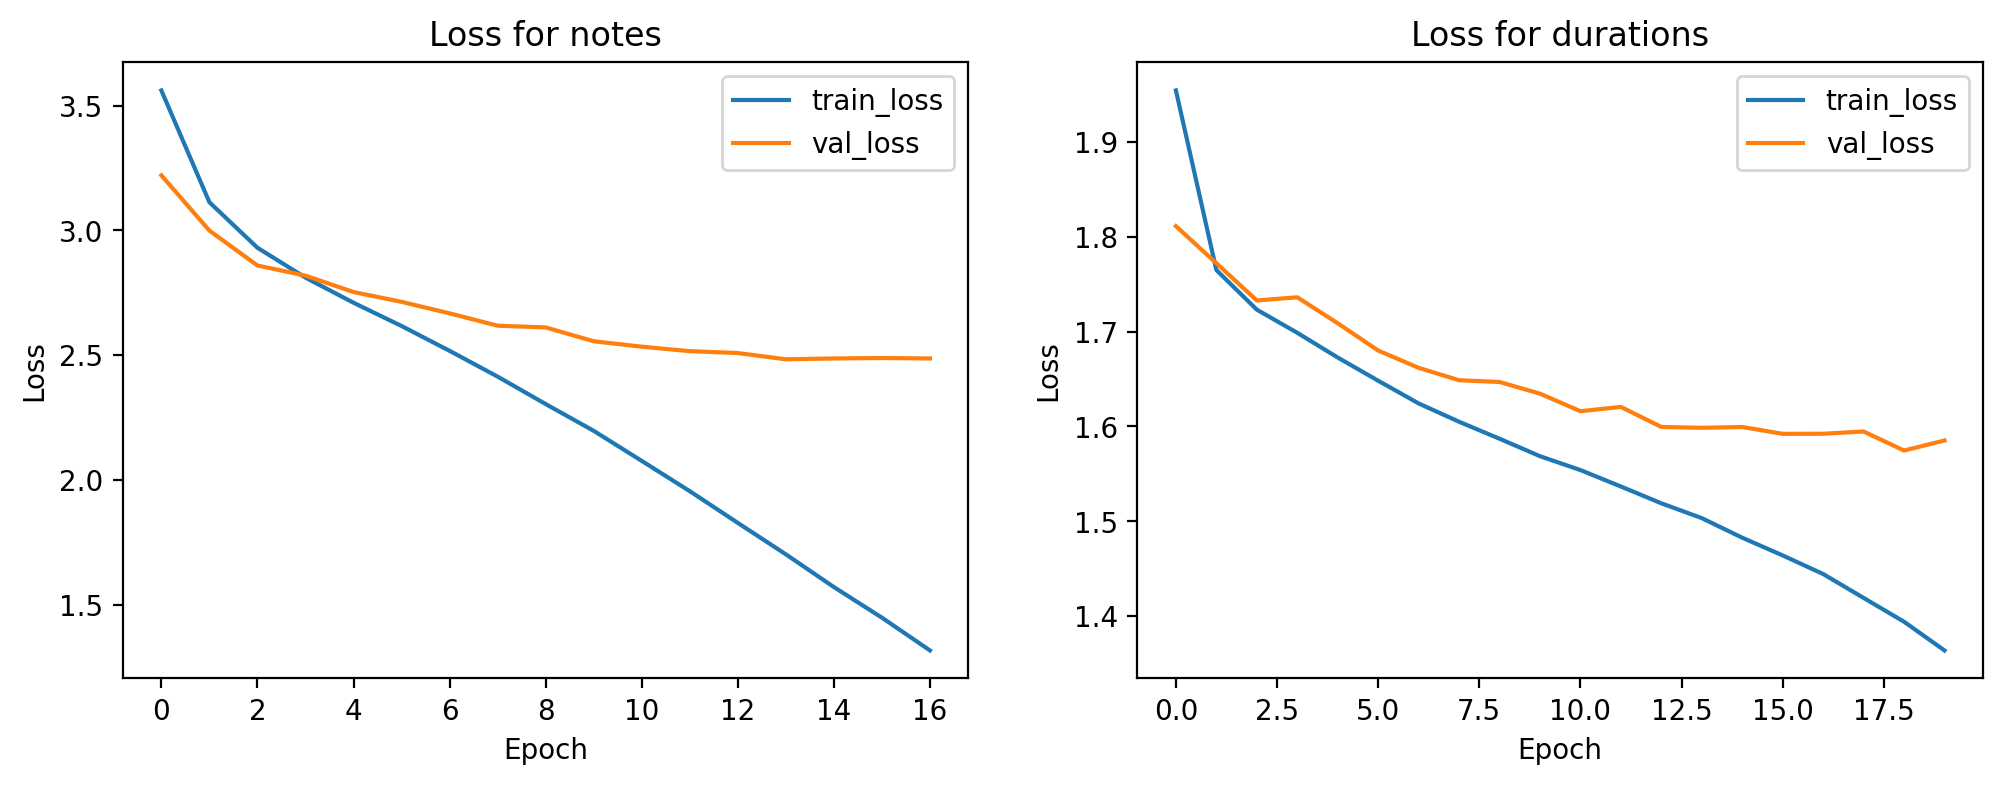

In [20]:
# Plot the training and validation loss for y1 and y2
plt.figure(figsize=(12, 4))

# Plot loss for y1
plt.subplot(1, 2, 1)
plt.plot(history_Y1.history['loss'], label='train_loss')
plt.plot(history_Y1.history['val_loss'], label='val_loss')
plt.title('Loss for notes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot loss for y2
plt.subplot(1, 2, 2)
plt.plot(history_Y2.history['loss'], label='train_loss')
plt.plot(history_Y2.history['val_loss'], label='val_loss')
plt.title('Loss for durations')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Stroing the model

In [ ]:
# save the model locally
model_Y1.save('pianix_Y1')
model_Y2.save('pianix_Y2')

### Testing the model

We'll evaluates the trained models on the test sets (X1_test, y1_test) and (X2_test, y2_test).

In [21]:
# Evaluate model for note numbers on the test set
loss_y1 = model_Y1.evaluate(X1_test, y1_test)
print("Test Loss_1:", loss_y1)


# Evaluate the model for note durations on the test set
loss_y2 = model_Y2.evaluate(X2_test, y2_test)
print("Test Loss_2:", loss_y2)

118/118 [==============================] - 0s 3ms/step - loss: 2.5573
Test Loss_1: 2.5573103427886963
118/118 [==============================] - 0s 3ms/step - loss: 1.5865
Test Loss_2: 1.586511254310608


Since the trained models provide probabilities, we'll utilize the `np.argmax` function to derive predictions. Subsequently, we'll visualize the predicted values against the actual values for the test set.


- `y1_test_prob = model_Y1.predict(X1_test)`: This line predicts the probabilities of the output classes (in this case, note numbers) for the test input data (`X1_test`) using the trained model `model_Y1`.

- `y1_test_pred = np.argmax(y1_test_prob, axis=1)`: After obtaining the predicted probabilities (`y1_test_prob`), this line identifies the class (note number) with the highest probability for each input sequence. The `np.argmax` function is used to find the index of the maximum value along the specified axis (axis=1 indicates along the class axis).

- `y2_test_prob = model_Y2.predict(X2_test)`: Similarly, this line predicts the probabilities of the output classes (in this case, durations) for the test input data (`X2_test`) using the trained model `model_Y2`.

- `y2_test_pred = np.argmax(y2_test_prob, axis=1)`: After obtaining the predicted probabilities (`y2_test_prob`), this line identifies the class (duration) with the highest probability for each input sequence.

In summary, these lines perform inference with the trained models to predict the most likely output class (note number or duration) for each input sequence in the test dataset.

In [22]:
y1_test_prob = model_Y1.predict(X1_test)
y1_test_pred = np.argmax(y1_test_prob, axis=1)

y2_test_prob = model_Y2.predict(X2_test)
y2_test_pred = np.argmax(y2_test_prob, axis=1)


118/118 [==============================] - 1s 2ms/step


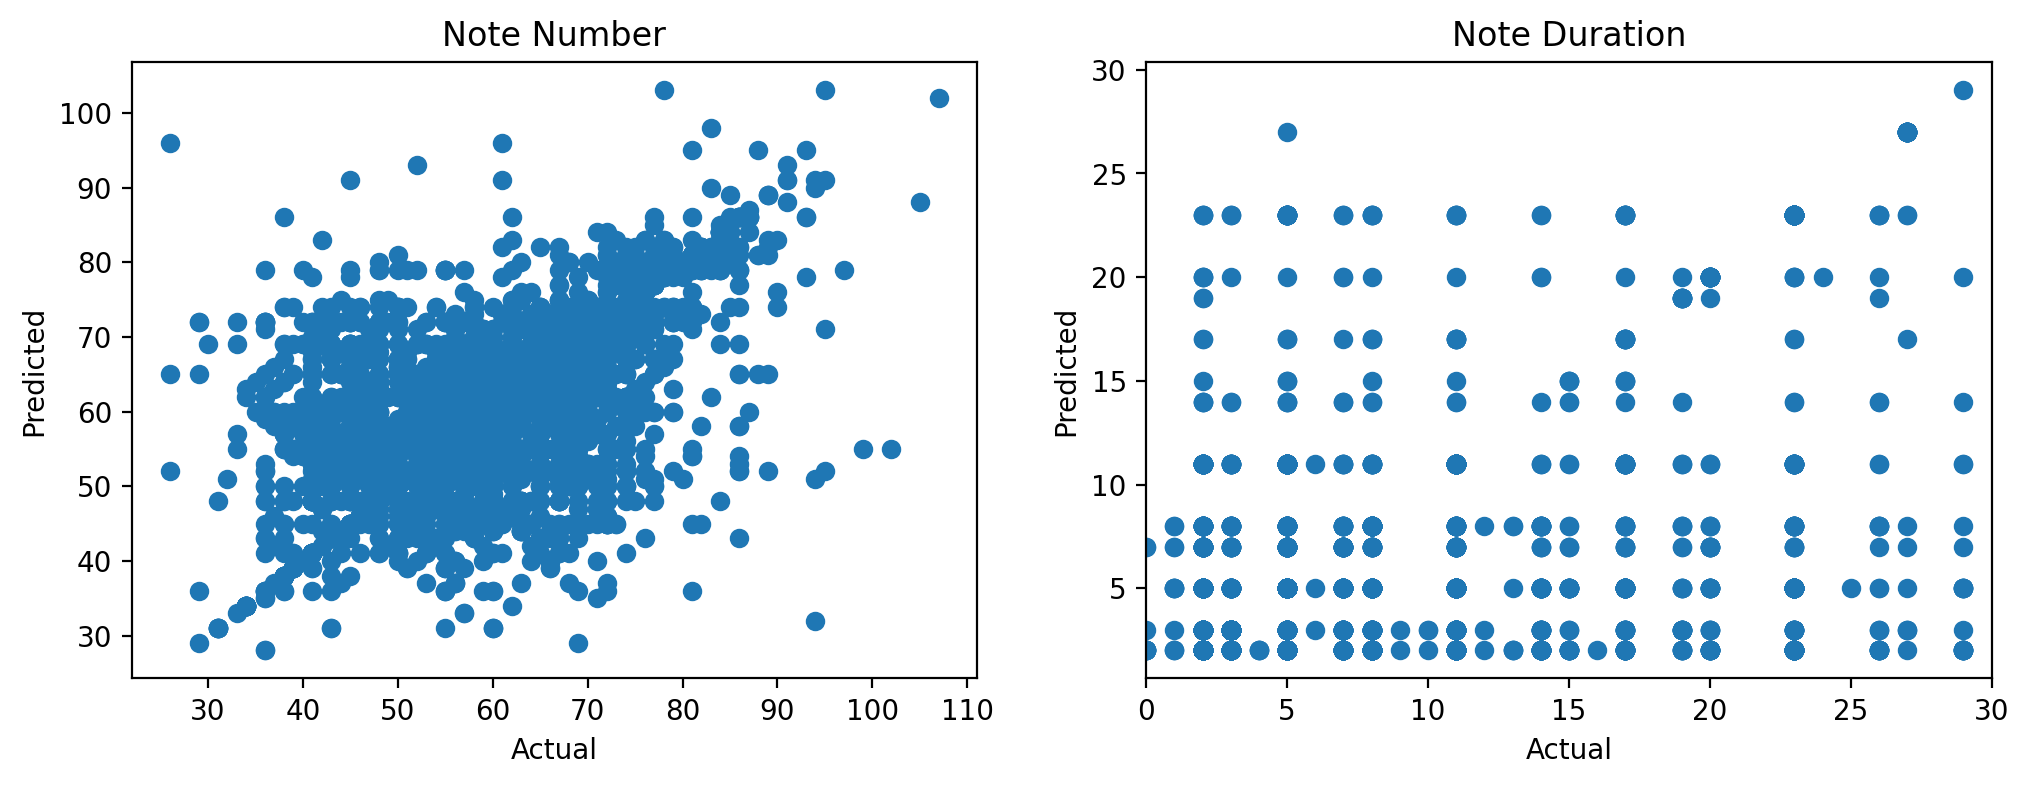

In [23]:

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot predictions vs actual for y1
ax1.scatter(y1_test, y1_test_pred)
ax1.set_title('Note Number')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax2.set_xlim([0,127])

# Plot predictions vs actual for y2
ax2.scatter(y2_test, y2_test_pred)
ax2.set_title('Note Duration')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_xlim([0,30])

# Show the plot
plt.show()


### Music generation

Here we'll generate music, i.e. note number/duration sequence using our trained models.

`generate_notes` function is used to generate the note number sequence:

- It takes two parameters: `melody_len`, representing the length of the desired melody sequence, and `seed`, which is used as the initial value for generating the sequence.
- It initializes a list `y` with length `melody_len` and fills it with the provided `seed` value.
- It iterates through the length of the melody (excluding the seed) and predicts the next note in the sequence using our trained model (`model_Y1`).
- For each iteration, it constructs a sequence of previous notes (`y_seq`) to feed into the model for prediction. If the sequence length is less than `max_seq_len`, it pads the sequence with zeros. Otherwise, it uses the last `max_seq_len` notes.
- It predicts the probabilities of the next note using the trained model and applies temperature scaling to adjust the probabilities.
- It selects the top k indices with the highest probabilities and scales them using a scaling factor.
- It normalizes the scaled probabilities and randomly selects a predicted note based on these probabilities.
- It ensures that the predicted note falls within the valid MIDI note range (0 to 127).
- Finally, it returns the generated sequence of notes.

In [60]:
# prompt: generate a random sequnece of y1 and y2, with a random seed for y1 and 1 for y2 using the trainfs model, with given melody_len

def generate_notes(melody_len, seed):

  y = [seed]*melody_len

  # Loop through melody length
  for i in tqdm(range(1, melody_len), desc='generating notes'):
    if i < max_seq_len:
        y_seq = [0] * (max_seq_len - i) + y[:i]
    else:
        y_seq = y1[i - max_seq_len:i]

    y_arr = np.array(y_seq, dtype=np.int16).reshape(1, -1)

    # Predict the next note probabilities
    probabilities = model_Y1.predict(y_arr, verbose=False)[0]

    # Adjust probabilities with temperature parameter
    temperature = 1.
    probabilities = np.exp(np.log(probabilities)/temperature)

    # Sample from top_k classes with highest probabilities
    top_k = 5
    top_k_indices = np.argpartition(probabilities, -top_k)[-top_k:]
    top_k_probabilities = probabilities[top_k_indices]

    # Adjust the scaling factor as needed
    frequent_note_scale = 0.75  
    top_k_probabilities_scaled = np.power(top_k_probabilities, frequent_note_scale)

    # Normalizing the probabilities
    top_k_probabilities = top_k_probabilities_scaled / np.sum(top_k_probabilities_scaled)

    # Predict next duration, ignoring the masked value.
    predicted_note = np.random.choice(top_k_indices, p=top_k_probabilities)
    while predicted_note>127:
      predicted_note = np.random.choice(top_k_indices, p=top_k_probabilities)

    # Append predictions to y1 and y2 lists
    y[i] = predicted_note


  return np.array(y)



Durations are generated through the `generate_durations` function, which follows a similar approach with slight variations. 

\* the outputs of `model_Y2` are divided by 12 to account for the previous multiplication of all duration values by 12.

In [65]:
def generate_durations(melody_len, seed=6):

  y = [seed]*melody_len

  # Loop through melody length
  for i in tqdm(range(1, melody_len), desc='generating durations'):
    if i < max_seq_len:
        y_seq = [0] * (max_seq_len - i) + y[:i]
    else:
        y_seq = y1[i - max_seq_len:i]

    y_arr = np.array(y_seq, dtype=np.int16).reshape(1, -1)

    # Predict the next note probabilities
    probabilities = model_Y2.predict(y_arr, verbose=False)[0]

    # Adjust probabilities with temperature parameter
    temperature = 1.
    probabilities = np.exp(np.log(probabilities)/temperature)

    # Sample from top_k classes with highest probabilities
    top_k = 5
    top_k_indices = np.argpartition(probabilities, -top_k)[-top_k:]
    top_k_probabilities = probabilities[top_k_indices]

    # Adjust the scaling factor as needed
    frequent_note_scale = 0.75 
    top_k_probabilities_scaled = np.power(top_k_probabilities, frequent_note_scale)

    # Normalizing the probabilities
    top_k_probabilities = top_k_probabilities_scaled / np.sum(top_k_probabilities_scaled)

    # Predict next duration, ignoring the masked value.
    predicted_duration = np.random.choice(top_k_indices, p=top_k_probabilities) / 12.
    while predicted_duration < 0.25:
      predicted_duration = np.random.choice(top_k_indices, p=top_k_probabilities) / 12.

    # Append predictions to y1 and y2 lists
    y[i] = predicted_duration

  return np.array(y)


Let's generate a random sequence of note numbers and durations using our trained models.
While it's possible to train a separate model for velocities, for simplicity, we'll assign a velocity of 100 to all notes here.

In [69]:
# Generate a random sequence of notes
melody_len = 120
seed_note = np.random.randint(0, 127)
seed_duration = .5

generated_notes = generate_notes(melody_len=melody_len, seed=seed_note)
print("\ngenerated_notes:", generated_notes)
generated_velocities = np.array([100]*melody_len)

generating notes: 100%|██████████| 119/119 [00:08<00:00, 13.62it/s]


generated_notes: [57 58 58 58 58 58 58 58 79 50 50 81 50 43 86 82 84 81 58 79 79 58 58 74
 43 70 58 58 74 67 67 77 77 58 58 58 74 74 75 63 77 41 63 77 55 75 75 41
 41 48 48 57 72 77 57 79 79 57 77 77 74 72 60 72 69 75 79 74 74 53 72 72
 72 74 74 72 74 86 98 55 50 58 70 50 69 74 46 45 50 74 58 58 79 74 72 67
 43 74 50 70 70 58 74 79 55 72 55 70 63 75 55 75 75 75 63 41 74 75 55 77]


In [70]:
# Generate a random sequence of durations
generated_durations = generate_durations(melody_len=melody_len, seed=seed_duration)
print("\n generated_durations:", generated_durations)

generating durations: 100%|██████████| 119/119 [00:06<00:00, 17.71it/s]


 generated_durations: [0.5        0.91666667 0.41666667 0.91666667 1.41666667 0.25
 0.41666667 0.91666667 0.41666667 0.66666667 0.58333333 0.66666667
 0.41666667 0.58333333 0.66666667 0.58333333 0.25       0.41666667
 0.58333333 0.41666667 0.66666667 0.58333333 0.41666667 0.58333333
 0.66666667 0.58333333 0.25       0.41666667 0.25       0.25
 0.25       0.58333333 0.66666667 0.41666667 0.25       0.66666667
 0.58333333 0.58333333 0.41666667 0.66666667 0.41666667 0.58333333
 0.41666667 0.66666667 0.41666667 0.41666667 0.41666667 0.25
 0.25       0.66666667 0.25       0.58333333 0.66666667 0.41666667
 0.58333333 0.66666667 0.41666667 0.25       0.41666667 0.25
 0.25       0.66666667 0.58333333 0.58333333 0.25       0.41666667
 0.25       0.66666667 0.66666667 0.66666667 0.58333333 0.25
 0.66666667 0.41666667 0.25       0.66666667 0.41666667 0.25
 0.25       0.66666667 0.25       0.66666667 0.66666667 0.58333333
 0.25       0.58333333 0.25       0.66666667 0.66666667 0.41666667
 0.58333

Here is a visualization of the music we generated.

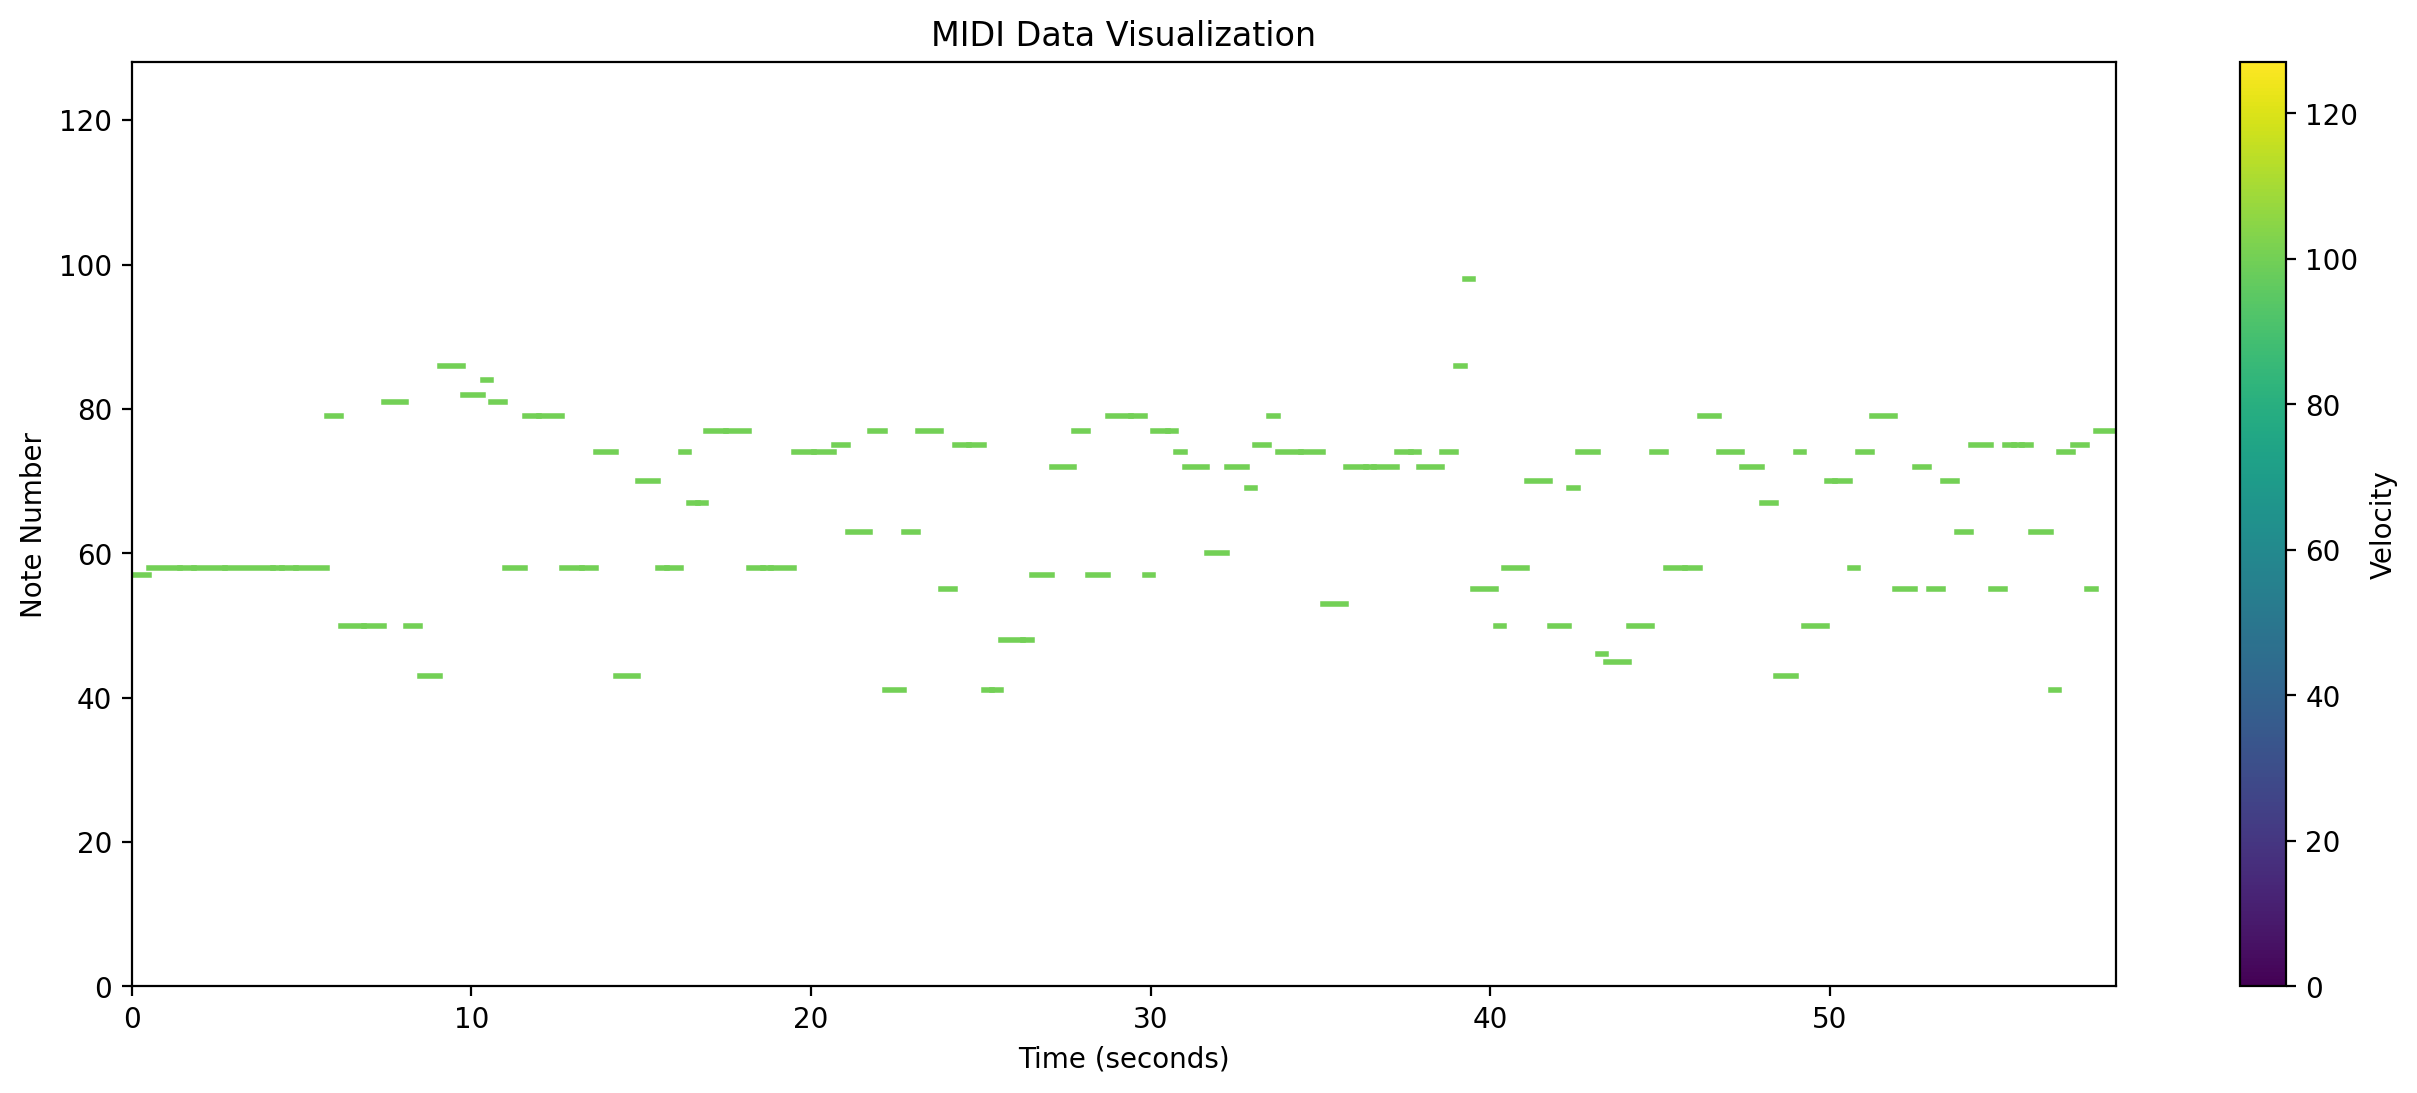

In [71]:
visualize_midi_data(generated_notes, generated_durations, generated_velocities)

Lastly, we can listen to the music generated by the model.

In [72]:
play_notes(generated_notes, generated_durations)